In [12]:
import pandas 
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from skimage.io import imread_collection
from tqdm import tqdm 
import os
import cv2
from keras.preprocessing.image import img_to_array

In [13]:
#your path 
col_dir = 'Sketch_data/Original/*.jpg'
dir = 'Sketch_data/Sketchs/*.jpg'

#creating a collection with the available images
original = imread_collection(col_dir)
sketch = imread_collection(dir)

In [14]:
SIZE = 256

image_path = 'Sketch_data/Original'
img_array = []

sketch_path = 'Sketch_data/Sketchs'
sketch_array = []

image_file = os.listdir(image_path)
sketch_file = os.listdir(sketch_path)

for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))

for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    


100%|██████████| 125/125 [00:01<00:00, 77.88it/s]


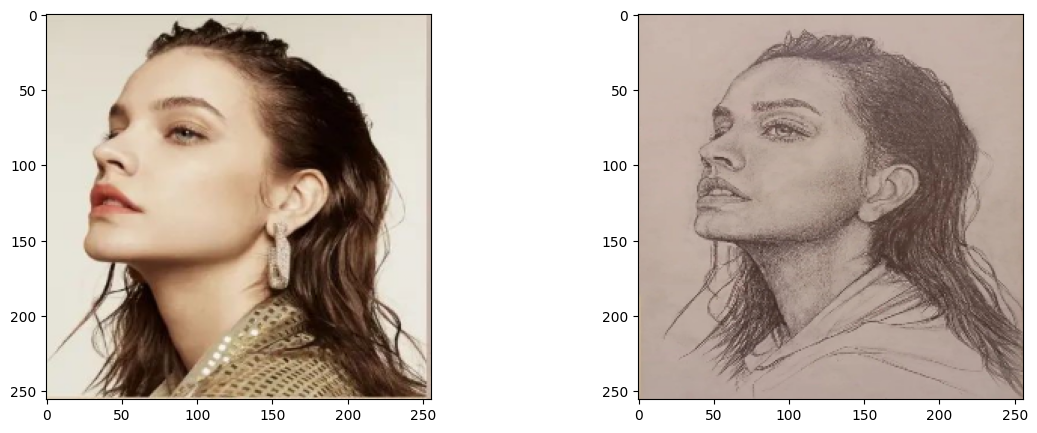

In [15]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(img_array[1])
plt.subplot(122)
plt.imshow(sketch_array[1])

In [16]:
train_sketch_image = np.reshape(sketch_array,(len(sketch_array),SIZE,SIZE,3))
train_image = np.reshape(img_array, (len(img_array),SIZE,SIZE,3))

In [17]:
encoder = Sequential([
    tf.keras.Input(shape = (SIZE, SIZE, 3)),
    tf.keras.layers.Conv2D(32, 4, padding="same" , activation="selu" , input_shape=[420,420,3]),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(64, 2,  padding="same" , activation="selu"),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(128, 2,  padding="same" , activation="selu"),
    tf.keras.layers.MaxPooling2D(pool_size=2)
])

decoder = Sequential([
    keras.layers.Conv2DTranspose(64, 2, strides=(2,2) , padding = "valid" , activation="selu" , input_shape=[52, 52, 128]),
    keras.layers.Conv2DTranspose(32 , kernel_size=4 , strides=2 , padding="same" , activation="selu"),
    keras.layers.Conv2DTranspose(16 , kernel_size=4 , strides=2 , padding="same" , activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=2 , strides=2 , padding="same" , activation="selu"),
    keras.layers.Reshape([832, 832 , 1])
])

auto_encoder = Sequential([encoder , decoder])

In [18]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [19]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU()) 
    return upsample

In [20]:
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(256,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)
    
  
    return tf.keras.Model(encoder_input, decoder_output)

In [21]:
model = model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_18 (Sequential)  (None, 127, 127, 16)      768       
                                                                 
 sequential_19 (Sequential)  (None, 62, 62, 32)        8320      
                                                                 
 sequential_20 (Sequential)  (None, 30, 30, 64)        32768     
                                                                 
 sequential_21 (Sequential)  (None, 14, 14, 128)       131584    
                                                                 
 sequential_22 (Sequential)  (None, 6, 6, 256)         525312    
                                                                 
 sequential_23 (Sequential)  (None, 2, 2, 512)         2099

In [59]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

history = model.fit(train_image, train_sketch_image, epochs = 1000, verbose = 0)

2024-07-18 11:48:12.033823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/sequential_24/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


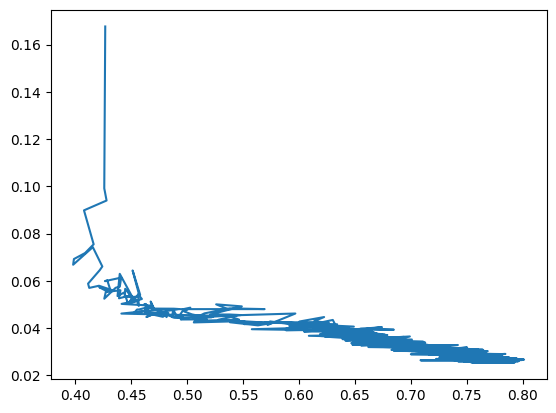

In [60]:
plt.plot(history.history['acc'] , history.history['loss'])

In [65]:
img = cv2.imread("test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (SIZE, SIZE))
img = img.astype('float32') / 255.0

In [66]:
pred_img = model.predict(img.reshape(1, 256, 256, 3))

1/1 [==============================] - 0s 27ms/step


In [63]:
img_sketch = cv2.imread("Sketch_data/Sketchs/2.jpg")
img_sketch = cv2.cvtColor(img_sketch, cv2.COLOR_BGR2RGB)
img_sketch = cv2.resize(img_sketch, (SIZE, SIZE))
img_sketch = img_sketch.astype('float32') / 255.0

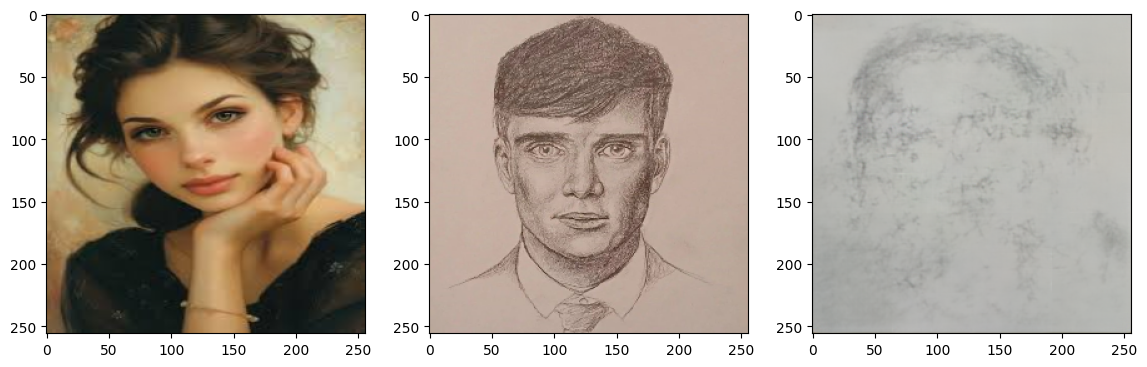

In [67]:
plt.figure(figsize=(14,5))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(img_sketch)
plt.subplot(133)
plt.imshow(pred_img.reshape(256, 256, 3))